# Pre-processing pipeline test
No reply - The Beatles

## Functions
### Create table with raw data 

In [9]:
import os
import numpy as np
import pandas as pd

def build_eeg_array_from_mat(
    hdr,
    mat_data,
    output_dir=".",
    file_prefix="EEG_data",
    save_format="npz",   # "npy" or "npz"
    return_dataframe=True
):
    """
    Build EEG array from .mat structure and save as .npy or .npz.

    Parameters
    ----------
    hdr : dict
        Header structure from .mat file
    mat_data : dict
        Full .mat dictionary
    output_dir : str
        Directory to save output
    file_prefix : str
        Prefix for output filename
    save_format : str
        "npy" (signal only) or "npz" (signal + metadata)
    return_dataframe : bool
        If True, also returns a DataFrame

    Returns
    -------
    signal : np.ndarray
    file_path : str
    (optional) EEG_Table : pandas.DataFrame
    """

    # Sampling frequency
    fs = float(hdr['Fs'][0,0])

    # Channel labels
    channels_raw = hdr['label'][0,0]
    channels = [str(row[0][0]) for row in channels_raw]

    # Extract signal
    signal = np.asarray(mat_data['data'], dtype=np.float32)

    # Fix orientation if needed
    if signal.shape[1] != len(channels) and signal.shape[0] == len(channels):
        signal = signal.T

    n_samples = signal.shape[0]
    time = np.arange(n_samples, dtype=np.float32) / fs

    os.makedirs(output_dir, exist_ok=True)

    # -------- SAVE --------
    if save_format == "npy":
        file_path = os.path.join(output_dir, f"{file_prefix}.npy")
        np.save(file_path, signal)

    elif save_format == "npz":
        file_path = os.path.join(output_dir, f"{file_prefix}.npz")
        np.savez(
            file_path,
            signal=signal,
            fs=fs,
            channels=channels,
            time=time
        )

    else:
        raise ValueError("save_format must be 'npy' or 'npz'")

    print(f"Saved EEG data to: {file_path}")
    print(f"Shape: {signal.shape}")
    print(f"Sampling frequency: {fs} Hz")

    if return_dataframe:
        EEG_Table = pd.DataFrame(signal, columns=channels)
        EEG_Table.insert(0, "Time", time)
        return signal, file_path, EEG_Table

    return signal, file_path


In [21]:
import pandas as pd
import numpy as np

def apply_amplitude_cutoff(
    EEG_Table: pd.DataFrame,
    threshold: float = 200
):
    """
    Clip EEG amplitudes at ±threshold (µV).

    Parameters
    ----------
    EEG_Table : pandas.DataFrame
        DataFrame containing 'Time' column OR time as index
    threshold : float
        Amplitude threshold in µV (default 200)

    Returns
    -------
    EEG_clipped : pandas.DataFrame
        DataFrame with amplitudes clipped
    """

    # Copiar para no modificar original
    EEG_clipped = EEG_Table.copy()

    # Si "Time" es columna → no tocarla
    if "Time" in EEG_clipped.columns:
        signal_cols = EEG_clipped.columns.drop("Time")
        EEG_clipped[signal_cols] = EEG_clipped[signal_cols].clip(
            lower=-threshold,
            upper=threshold
        )
    else:
        # Si Time es índice
        EEG_clipped = EEG_clipped.clip(
            lower=-threshold,
            upper=threshold
        )

    return EEG_clipped


### Shaded threshold plot

In [8]:
import matplotlib.pyplot as plt

def plot_eeg_with_shaded_threshold(
    EEG_Table,
    threshold=200,          # µV
    time_window=None,
    figsize=(12,6)
):
    """
    Plot EEG signals with grey shaded region between ±threshold (µV).

    Parameters
    ----------
    EEG_Table : pandas.DataFrame
        Must contain 'Time' column
    threshold : float
        Amplitude threshold in µV (default 200)
    time_window : tuple or None
        (start_time, end_time) in seconds
    figsize : tuple
        Figure size
    """

    # Apply time window if provided
    if time_window is not None:
        start, end = time_window
        EEG_Table = EEG_Table[
            (EEG_Table["Time"] >= start) &
            (EEG_Table["Time"] <= end)
        ]

    EEG_TimeTable = EEG_Table.set_index("Time")

    fig, axes = plt.subplots(
        nrows=EEG_TimeTable.shape[1],
        ncols=1,
        sharex=True,
        figsize=figsize
    )

    # If only one channel
    if EEG_TimeTable.shape[1] == 1:
        axes = [axes]

    for ax, channel in zip(axes, EEG_TimeTable.columns):

        # Plot signal
        ax.plot(EEG_TimeTable.index, EEG_TimeTable[channel])

        # Grey shaded region between ±threshold
        ax.axhspan(-threshold, threshold, alpha=0.15)

        # Horizontal lines at ±threshold
        ax.axhline(threshold, linestyle="--")
        ax.axhline(-threshold, linestyle="--")

        ax.set_ylabel(channel)

    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


### Create raw signal plot

In [10]:
import matplotlib.pyplot as plt

def plot_eeg_signals(
    EEG_Table,
    time_window=None,      # tuple (start, end) in seconds
    y_limit=None,          # tuple (-200, 200) for cut-off
    figsize=(12,6)
):
    """
    Plot EEG signals from a DataFrame with Time column.

    Parameters
    ----------
    EEG_Table : pandas.DataFrame
        DataFrame containing 'Time' + EEG channels
    time_window : tuple or None
        (start_time, end_time) in seconds
    y_limit : tuple or None
        (ymin, ymax) for visual cut-off (e.g. (-200,200))
    figsize : tuple
        Figure size
    """

    # Apply time window if provided
    if time_window is not None:
        start, end = time_window
        EEG_Table = EEG_Table[
            (EEG_Table["Time"] >= start) &
            (EEG_Table["Time"] <= end)
        ]

    EEG_TimeTable = EEG_Table.set_index("Time")

    fig, axes = plt.subplots(
        nrows=EEG_TimeTable.shape[1],
        ncols=1,
        sharex=True,
        figsize=figsize
    )

    # If only one channel
    if EEG_TimeTable.shape[1] == 1:
        axes = [axes]

    for ax, channel in zip(axes, EEG_TimeTable.columns):
        ax.plot(EEG_TimeTable.index, EEG_TimeTable[channel])
        ax.set_ylabel(channel)

        if y_limit is not None:
            ax.set_ylim(y_limit)

    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


## Band-pass filter

In [26]:
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfiltfilt

def bandpass_filter_eegwin(
    EEG_win: pd.DataFrame,
    lowcut: float = 0.5,
    highcut: float = 40.0,
    order: int = 4,
    check_nans: bool = True
):
    """
    Band-pass robusto usando SOS + sosfiltfilt (fase cero).

    EEG_win:
      - index: tiempo en segundos (numérico, creciente)
      - columns: canales
      - values: amplitud
    """

    # --- 1) Inferir fs desde el índice ---
    t = EEG_win.index.to_numpy(dtype=float)
    if t.size < 3:
        raise ValueError("Muy pocas muestras para inferir fs y filtrar (necesitas >= 3).")

    dt = np.median(np.diff(t))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("El índice de tiempo debe ser numérico, finito y estrictamente creciente.")

    fs = 1.0 / dt
    nyq = fs / 2.0

    # --- 2) Validaciones de cortes ---
    if lowcut <= 0:
        raise ValueError("lowcut debe ser > 0 Hz.")
    if highcut >= nyq:
        raise ValueError(f"highcut ({highcut} Hz) debe ser < Nyquist ({nyq:.2f} Hz).")
    if lowcut >= highcut:
        raise ValueError("lowcut debe ser < highcut.")

    # --- 3) NaNs ---
    if check_nans and EEG_win.isna().any().any():
        raise ValueError("EEG_win contiene NaNs. Rellena/interpola antes de filtrar.")

    # --- 4) Diseñar filtro ---
    sos = butter(order, [lowcut, highcut], btype="band", fs=fs, output="sos")

    # --- 5) Filtrar ---
    X = EEG_win.to_numpy(dtype=float)  # (n_samples, n_channels)
    try:
        Xf = sosfiltfilt(sos, X, axis=0)
    except ValueError as e:
        raise ValueError(
            f"No se pudo filtrar (posible ventana corta/padding). "
            f"Prueba una ventana más larga o baja el orden. Error: {e}"
        )

    EEG_win_filt = pd.DataFrame(Xf, index=EEG_win.index, columns=EEG_win.columns)
    return EEG_win_filt, fs


## Pre-processing test

In [5]:
import os
from scipy.io import loadmat
# el unico cambio que haria para hacerlo con todos seria loopear por cada paciente y dentro de ahi por cada .mat
file_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/XB47Y_1.mat"
abs_path = os.path.abspath(file_path)

data_XB47Y_1 = loadmat(abs_path)
hdr = data_XB47Y_1['hdr']

signal, path, EEG_Table = build_eeg_array_from_mat(
    hdr=data_XB47Y_1["hdr"],
    mat_data=data_XB47Y_1,
    output_dir="results",
    file_prefix="XB47Y_1",
    save_format="npz",
    return_dataframe=True  
)


Saved EEG data to: results/XB47Y_1.npz
Shape: (28566, 2)
Sampling frequency: 207.0310546581987 Hz


/tmp/ipykernel_1323582/3401177230.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fs = float(hdr['Fs'][0,0])


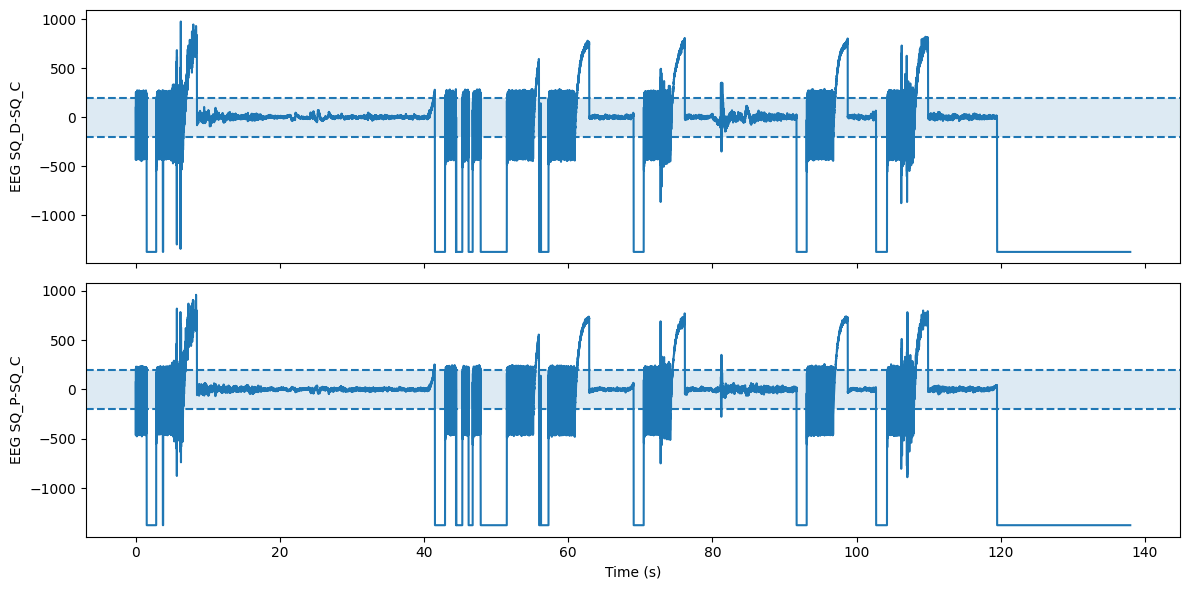

In [6]:
plot_eeg_with_shaded_threshold(EEG_Table)


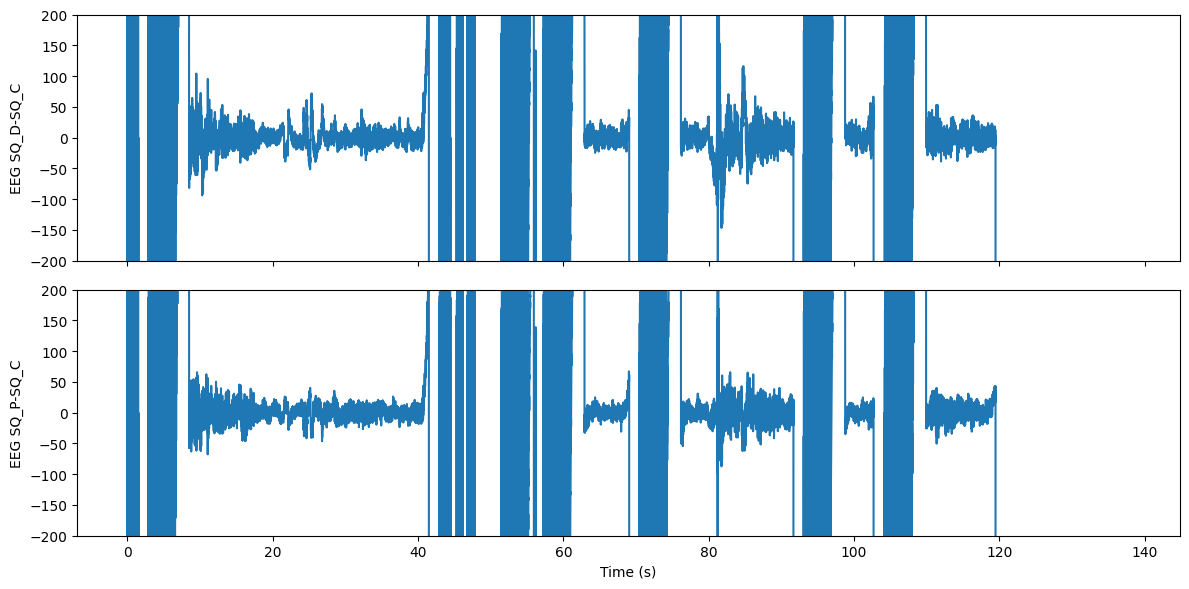

In [29]:
plot_eeg_signals(
    EEG_Table,
    y_limit=(-200, 200)
)


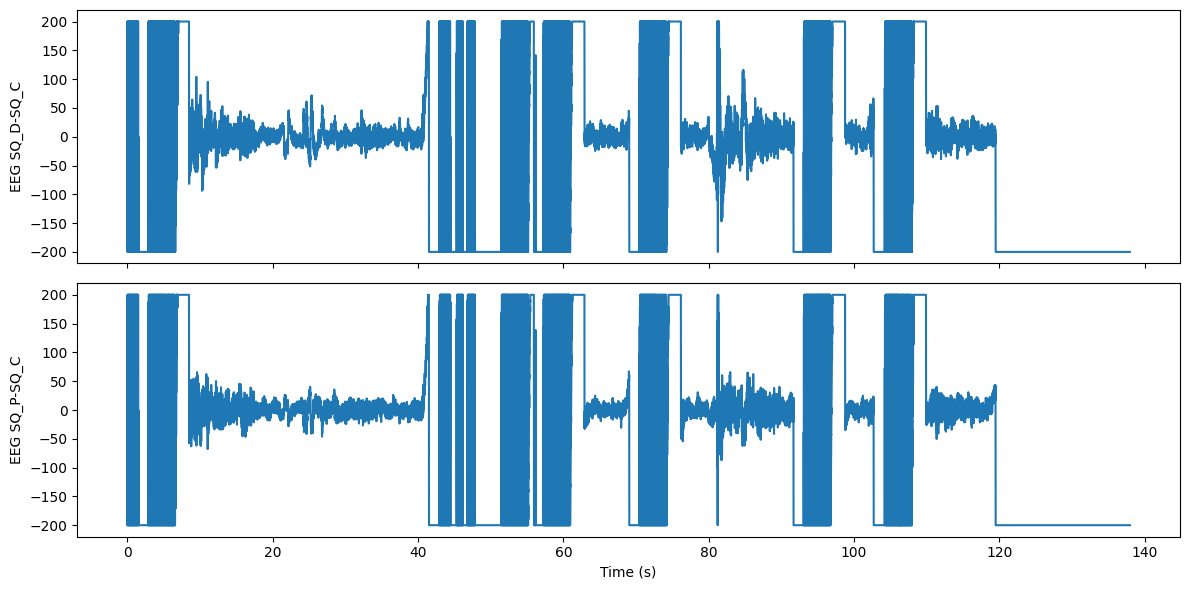

In [22]:
# this is a clipped table, in order to not modify the original 
EEG_cut = apply_amplitude_cutoff(EEG_Table, threshold=200)
plot_eeg_signals(
    EEG_cut
)


## BAND PASS and notch filtering:
A band-pass filter keeps only the components of an EEG signal that fall within a specific frequency range, while attenuating slower and faster fluctuations outside that band. In the context of EEG analysis, applying a 0.5–40 Hz band-pass filter removes very low-frequency drifts caused by electrode movement, sweating, or baseline instability, as well as high-frequency noise mainly originating from muscle activity and external electrical sources. This preprocessing step preserves the physiologically meaningful rhythms and transient events—such as spikes and sharp waves—that are most relevant for clinical interpretation and for downstream tasks like seizure detection or machine-learning-based feature extraction, while improving signal-to-noise ratio and model stability.

slow signal: x₀ x₁ x₂ x₃ │ │ │ │ 10 10.1 10.2 10.3 µV

fast signal: x₀ x₁ x₂ x₃ │ │ │ │ 10 -10 10 -10 µV

this is the example of a signal that changes at 10hz: 10 ─ 0 ─ 10 ─ 0 ─ 10

this is the example of a signal that changes at 80hz, which is out of the established higher cut (40hz): 10 -10 10 -10 10 -10

Butterworth measures how the signal correlates with itself along time y[n] = a₁·y[n−1] + a₂·y[n−2] + b₀·x[n] + b₁·x[n−1] + b₂·x[n−2]

b, a = butter(order, [low, high], btype="band") “Construí un sistema matemático que, cuando vea una señal en el tiempo, deje pasar patrones que cambian entre 0.5 y 40 veces por segundo (dado mi fs), y atenúe los demás.”

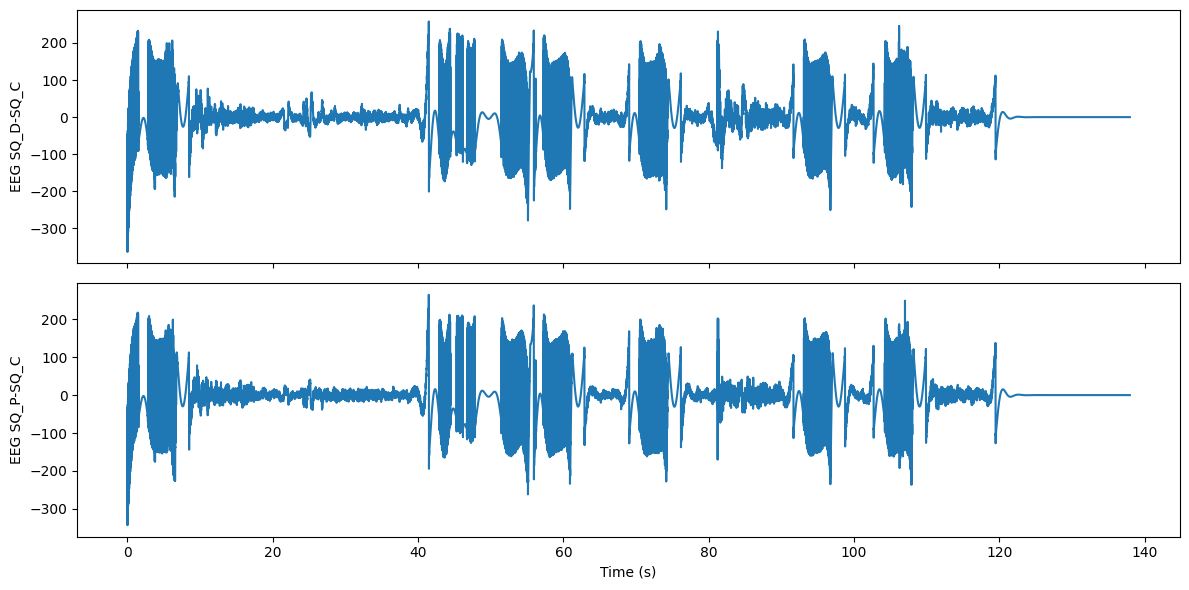

In [40]:
EEG_TimeIndexed = EEG_cut.set_index("Time")
EEG_filt, fs = bandpass_filter_eegwin(
    EEG_TimeIndexed,
    lowcut=0.5,
    highcut=40,
    order=4
)
plot_eeg_signals(
    EEG_filt.reset_index()
    )
# with the band-pass filter

In [37]:
EEG_filt
print(f)


207.0647709320695


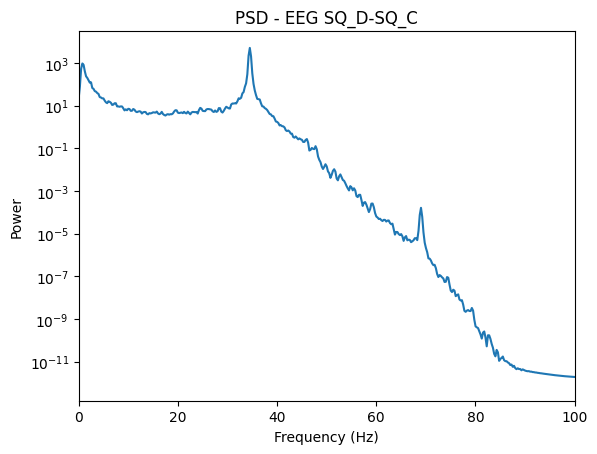

In [35]:
from scipy.signal import welch
import matplotlib.pyplot as plt



# seleccionar canal
signal = EEG_filt["EEG SQ_D-SQ_C"].values

f, Pxx = welch(signal, fs=fs, nperseg=fs*4)

plt.figure()
plt.semilogy(f, Pxx)
plt.xlim(0, 100)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("PSD - EEG SQ_D-SQ_C")
plt.show()


In [ ]:
# now the same but without band pass


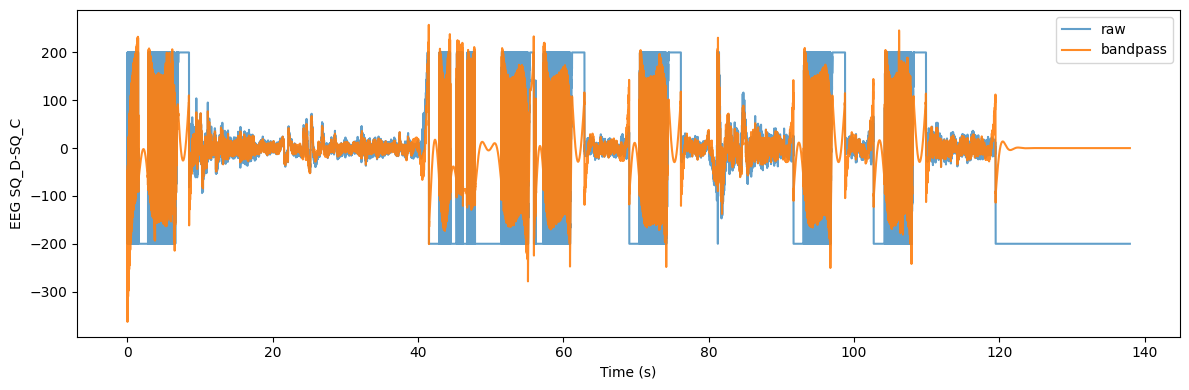

In [34]:
EEG_cut_i  = EEG_cut.set_index("Time") if "Time" in EEG_cut.columns else EEG_cut
EEG_filt_i = EEG_filt.set_index("Time") if "Time" in EEG_filt.columns else EEG_filt

ch = EEG_cut_i.columns[0]  # ahora sí: seguro es un canal

plt.figure(figsize=(12,4))
plt.plot(EEG_cut_i.index, EEG_cut_i[ch], label="raw", alpha=0.7)
plt.plot(EEG_filt_i.index, EEG_filt_i[ch], label="bandpass", alpha=0.9)
plt.xlabel("Time (s)")
plt.ylabel(ch)
plt.legend()
plt.tight_layout()
plt.show()

